In [1]:
!date

Fri Jul 30 09:49:53 PDT 2021


# Splitting clusters on isoforms

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy import stats


import sys
sys.path.append('../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

/home/nmarkari/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
cluster_cmap = pd.read_csv('../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='cluster_label',usecols=['cluster_label','cluster_color'])
cluster_cmap = cluster_cmap.drop_duplicates()
cluster_cmap = cluster_cmap.cluster_color.apply(lambda x: mcolors.to_rgb(x) )
cluster_cmap = cluster_cmap.to_dict()

In [4]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 25
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [5]:
import ast

In [6]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [7]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to genes with more than one isoform

In [8]:
gene = gene[:,gene.var["num_isoforms"]>1]

In [9]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 173 ms, sys: 9.02 ms, total: 182 ms
Wall time: 181 ms


In [10]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [11]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 18175 × 12859
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'scaled'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 18175 × 68232
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length

In [12]:
isoform = isoform[isoform.obs.sort_values(["cluster_label", "cell_id"]).index]
gene = gene[gene.obs.sort_values(["cluster_label", "cell_id"]).index]

In [13]:
False in (gene.obs.cluster_label == isoform.obs.cluster_label)

False

In [14]:
n_cells =30
big_enough_clusters =gene.obs["cluster_label"].value_counts()[gene.obs["cluster_label"].value_counts()>n_cells].index.values
isoform = isoform[isoform.obs["cluster_label"].isin(big_enough_clusters)].copy()
gene = gene[gene.obs["cluster_label"].isin(big_enough_clusters)].copy()


In [15]:
isoform.obs

,cell_id,cluster_id,cluster_label,subclass_id,subclass_label,region_label,class_label,cluster_color,class_id,cell_counts,leiden,louvain
792-6,SM-GE671_S260_E1-50,3,3_Meis2,28,Meis2,PL-ILA,GABAergic,#D62228,0,420574.15625,31,25
904-1,SM-GE8ZH_S044_E1-50,3,3_Meis2,28,Meis2,ORB,GABAergic,#D62228,0,513180.03125,31,25
905-1,SM-GE8ZH_S045_E1-50,3,3_Meis2,28,Meis2,ORB,GABAergic,#D62228,0,589060.06250,26,21
906-1,SM-GE8ZH_S048_E1-50,3,3_Meis2,28,Meis2,ORB,GABAergic,#D62228,0,559004.18750,31,25
907-1,SM-GE8ZH_S049_E1-50,3,3_Meis2,28,Meis2,ORB,GABAergic,#D62228,0,646412.62500,31,25
...,...,...,...,...,...,...,...,...,...,...,...,...
1567-1,SM-GE91J_S118_E1-50,376,376_Astro,0,Astro,ENTl,Non-Neuronal,#332F26,2,450472.84375,27,22
1574-1,SM-GE91J_S200_E1-50,376,376_Astro,0,Astro,ENTl,Non-Neuronal,#332F26,2,749787.25000,27,22
1578-1,SM-GE91J_S214_E1-50,376,376_Astro,0,Astro,ENTl,Non-Neuronal,#332F26,2,715094.12500,27,22
1589-1,SM-GE91J_S300_E1-50,376,376_Astro,0,Astro,ENTl,Non-Neuronal,#332F26,2,527572.93750,27,22


# Cluster on the subclasses to see if there is an isoform that splits one 

In [16]:
from sklearn.cluster import KMeans

In [17]:
clusters = np.unique(isoform.obs.cluster_label.values)

In [18]:
%%time

# isoform level
check = []
files = []
for c in clusters:
    tmp = isoform[isoform.obs.eval(f"cluster_label== '{c}'")].copy()
    kmeans = KMeans(n_clusters=2, random_state=state).fit(tmp.X)
    tmp.obs["km"] = kmeans.labels_
    files.append(tmp)
    
    check += list(kmeans.labels_)

CPU times: user 28min 9s, sys: 35min 23s, total: 1h 3min 32s
Wall time: 3min 1s


In [19]:
new_isoform = files[0].concatenate(*files[1:])

In [20]:
False in (new_isoform.obs.km.values == np.array(check))

False

# Plot new clusters

In [21]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [22]:
shape = np.round(np.sqrt(new_isoform.obs.cluster_label.nunique())).astype(int)
n_clusters = new_isoform.obs.cluster_label.nunique()

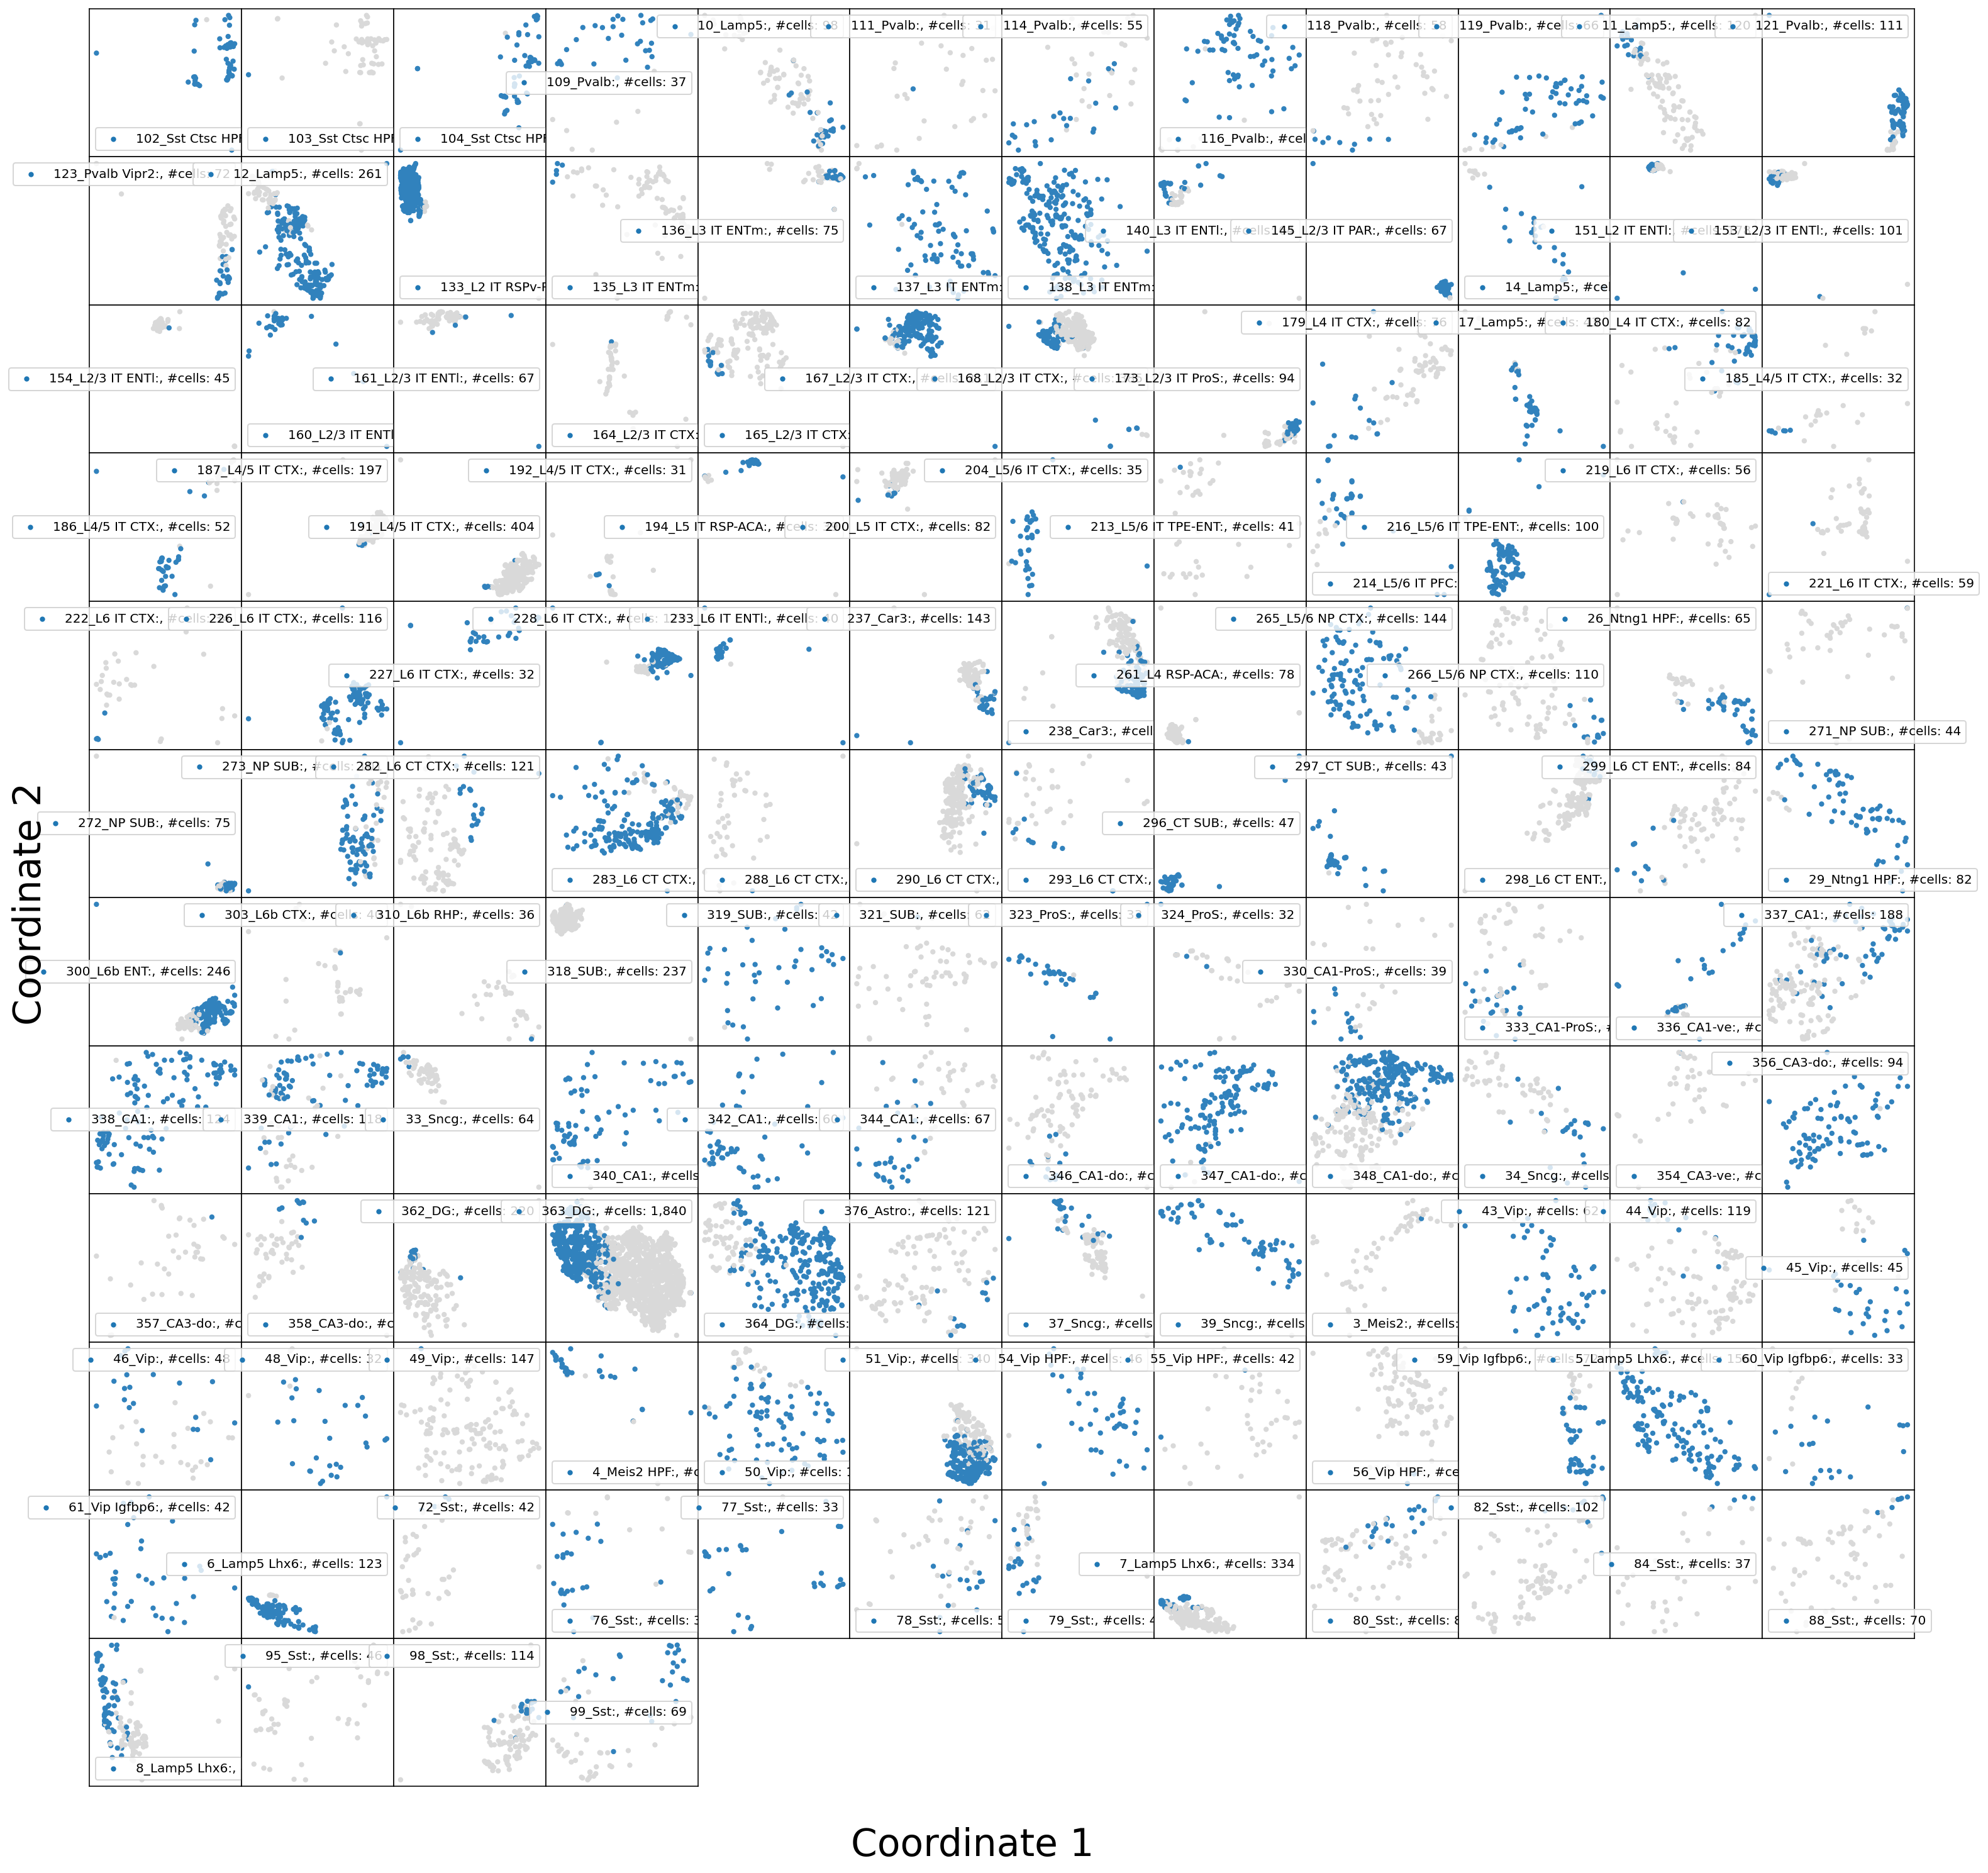

In [23]:
fig, ax = plt.subplots(figsize=(26,26), ncols=shape, nrows=shape)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, n_clusters)


for sidx, (ax, cluster) in enumerate(zip(axs, clusters)):
    tmp = new_isoform[new_isoform.obs.eval(f"cluster_label == '{cluster}'")]

    ax = axs[sidx]
    XX = tmp.obsm["X_nca_tsne"]
    x = XX[:,0]
    y = XX[:,1]
    color = tmp.obs.km.astype(int)
    ax.scatter(x, y,s=10, c = color, cmap="tab20c", label=cluster+":, #cells: {:,}".format(x.shape[0]))# label=cluster+", #clusters {:,}".format(np.unique(color).shape[0]))
    ax.legend(fontsize=10)
    ax.set(**{
        "xticks": [],
        "xticklabels": [],
        "yticks": [],
        "yticklabels": [],
    })
    
fig.text(0.5, 0.1, 'Coordinate 1', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'Coordinate 2', ha='center', va='center', rotation='vertical', fontsize=30)    

plt.savefig("../../figures/kmeans_split_all_clusters.png",bbox_inches='tight', dpi=300)


fig.show()

In [24]:
gene.obs["km"] = new_isoform.obs.km.values

In [25]:
isoform = new_isoform.copy()

# determine the isoforms

In [26]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    color = kwd.get("color", "#D43F3A")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


# do for all clusters with a certain number of cells per cluster

In [27]:
%%time
n_cells = 109
fraction = 0.20

de_clusters = []
de_genes = []
de_isoforms = []
for cidx, c in enumerate(clusters):
    print(f"{cidx+1} of {len(clusters)}: {c}")
    tmp_isoform = isoform[isoform.obs.eval(f"cluster_label == '{c}'")].copy()
    tmp_gene    = gene[gene.obs.eval(f"cluster_label == '{c}'")].copy()

    if tmp_isoform.shape[0] >= n_cells: # cluster must have at least 109 cells
        if (tmp_isoform.obs.km.value_counts()/tmp_isoform.shape[0] > fraction).sum() == 2: # must have at least 20% of total cells in a clusters
                de_clusters.append(c)
                
                ####### Genes
                mat           = tmp_gene.layers["log1p"].todense()
                components    = tmp_gene.obs.cell_id.values
                features      = tmp_gene.var.gene_name.values
                assignments   = tmp_gene.obs.km.values

                # parameters
                unique        = np.unique(assignments)
                nan_cutoff    = 0.9 # of elements in cluster
                corr_method   = "bonferroni"
                
                p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
                p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

                s = stat

                markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

                # convert the 0 pvalues to the smallest possible float
                markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
                markers_gene["n_isoforms"] = markers_gene.name.map(gene.var.num_isoforms)
                de_genes.append(markers_gene)
                
                

                ######### Isoforms
                mat           = tmp_isoform.layers["log1p"].todense()
                components    = tmp_isoform.obs.cell_id.values
                features      = tmp_isoform.var.transcript_name.values
                assignments   = tmp_isoform.obs.km.values

                # parameters
                unique        = np.unique(assignments)
                nan_cutoff    = 0.9 # of elements in cluster
                corr_method   = "bonferroni"
                
                
                p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
                p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

                s = stat

                markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

                # convert the 0 pvalues to the smallest possible float
                markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
                de_isoforms.append(markers_isoform)

1 of 136: 102_Sst Ctsc HPF
2 of 136: 103_Sst Ctsc HPF
3 of 136: 104_Sst Ctsc HPF
4 of 136: 109_Pvalb
5 of 136: 10_Lamp5
6 of 136: 111_Pvalb
7 of 136: 114_Pvalb
8 of 136: 116_Pvalb
9 of 136: 118_Pvalb
10 of 136: 119_Pvalb
11 of 136: 11_Lamp5
12 of 136: 121_Pvalb


30-Jul-21 09:54:43 - 1 of 2 assignments: 0
30-Jul-21 09:54:43 - 2 of 2 assignments: 1
30-Jul-21 09:54:44 - 1 of 2 assignments: 0
30-Jul-21 09:54:44 - 2 of 2 assignments: 1


13 of 136: 123_Pvalb Vipr2
14 of 136: 12_Lamp5


30-Jul-21 09:54:44 - 1 of 2 assignments: 0
30-Jul-21 09:54:44 - 2 of 2 assignments: 1
30-Jul-21 09:54:44 - 1 of 2 assignments: 0
30-Jul-21 09:54:44 - 2 of 2 assignments: 1


15 of 136: 133_L2 IT RSPv-POST-PRE
16 of 136: 135_L3 IT ENTm
17 of 136: 136_L3 IT ENTm
18 of 136: 137_L3 IT ENTm
19 of 136: 138_L3 IT ENTm
20 of 136: 140_L3 IT ENTl
21 of 136: 145_L2/3 IT PAR
22 of 136: 14_Lamp5
23 of 136: 151_L2 IT ENTl


30-Jul-21 09:54:46 - 1 of 2 assignments: 0
30-Jul-21 09:54:46 - 2 of 2 assignments: 1
30-Jul-21 09:54:46 - 1 of 2 assignments: 0
30-Jul-21 09:54:46 - 2 of 2 assignments: 1


24 of 136: 153_L2/3 IT ENTl
25 of 136: 154_L2/3 IT ENTl
26 of 136: 160_L2/3 IT ENTl
27 of 136: 161_L2/3 IT ENTl
28 of 136: 164_L2/3 IT CTX
29 of 136: 165_L2/3 IT CTX
30 of 136: 167_L2/3 IT CTX
31 of 136: 168_L2/3 IT CTX


30-Jul-21 09:54:48 - 1 of 2 assignments: 0
30-Jul-21 09:54:48 - 2 of 2 assignments: 1
30-Jul-21 09:54:48 - 1 of 2 assignments: 0
30-Jul-21 09:54:48 - 2 of 2 assignments: 1


32 of 136: 173_L2/3 IT ProS
33 of 136: 179_L4 IT CTX
34 of 136: 17_Lamp5
35 of 136: 180_L4 IT CTX
36 of 136: 185_L4/5 IT CTX
37 of 136: 186_L4/5 IT CTX
38 of 136: 187_L4/5 IT CTX
39 of 136: 191_L4/5 IT CTX
40 of 136: 192_L4/5 IT CTX
41 of 136: 194_L5 IT RSP-ACA
42 of 136: 200_L5 IT CTX
43 of 136: 204_L5/6 IT CTX
44 of 136: 213_L5/6 IT TPE-ENT
45 of 136: 214_L5/6 IT PFC
46 of 136: 216_L5/6 IT TPE-ENT
47 of 136: 219_L6 IT CTX
48 of 136: 221_L6 IT CTX
49 of 136: 222_L6 IT CTX
50 of 136: 226_L6 IT CTX
51 of 136: 227_L6 IT CTX


30-Jul-21 09:54:51 - 1 of 2 assignments: 0
30-Jul-21 09:54:51 - 2 of 2 assignments: 1


52 of 136: 228_L6 IT CTX


30-Jul-21 09:54:51 - 1 of 2 assignments: 0
30-Jul-21 09:54:51 - 2 of 2 assignments: 1


53 of 136: 233_L6 IT ENTl
54 of 136: 237_Car3


30-Jul-21 09:54:51 - 1 of 2 assignments: 0
30-Jul-21 09:54:51 - 2 of 2 assignments: 1
30-Jul-21 09:54:51 - 1 of 2 assignments: 0
30-Jul-21 09:54:52 - 2 of 2 assignments: 1


55 of 136: 238_Car3


30-Jul-21 09:54:52 - 1 of 2 assignments: 0
30-Jul-21 09:54:52 - 2 of 2 assignments: 1
30-Jul-21 09:54:52 - 1 of 2 assignments: 0
30-Jul-21 09:54:52 - 2 of 2 assignments: 1


56 of 136: 261_L4 RSP-ACA
57 of 136: 265_L5/6 NP CTX
58 of 136: 266_L5/6 NP CTX
59 of 136: 26_Ntng1 HPF
60 of 136: 271_NP SUB
61 of 136: 272_NP SUB
62 of 136: 273_NP SUB
63 of 136: 282_L6 CT CTX
64 of 136: 283_L6 CT CTX
65 of 136: 288_L6 CT CTX
66 of 136: 290_L6 CT CTX


30-Jul-21 09:54:54 - 1 of 2 assignments: 0
30-Jul-21 09:54:54 - 2 of 2 assignments: 1
30-Jul-21 09:54:54 - 1 of 2 assignments: 0
30-Jul-21 09:54:54 - 2 of 2 assignments: 1


67 of 136: 293_L6 CT CTX
68 of 136: 296_CT SUB
69 of 136: 297_CT SUB
70 of 136: 298_L6 CT ENT
71 of 136: 299_L6 CT ENT
72 of 136: 29_Ntng1 HPF
73 of 136: 300_L6b ENT


30-Jul-21 09:54:55 - 1 of 2 assignments: 0
30-Jul-21 09:54:55 - 2 of 2 assignments: 1
30-Jul-21 09:54:56 - 1 of 2 assignments: 0
30-Jul-21 09:54:56 - 2 of 2 assignments: 1


74 of 136: 303_L6b CTX
75 of 136: 310_L6b RHP
76 of 136: 318_SUB
77 of 136: 319_SUB
78 of 136: 321_SUB
79 of 136: 323_ProS
80 of 136: 324_ProS
81 of 136: 330_CA1-ProS
82 of 136: 333_CA1-ProS
83 of 136: 336_CA1-ve
84 of 136: 337_CA1


30-Jul-21 09:54:57 - 1 of 2 assignments: 0
30-Jul-21 09:54:57 - 2 of 2 assignments: 1
30-Jul-21 09:54:57 - 1 of 2 assignments: 0
30-Jul-21 09:54:57 - 2 of 2 assignments: 1


85 of 136: 338_CA1
86 of 136: 339_CA1


30-Jul-21 09:54:58 - 1 of 2 assignments: 0
30-Jul-21 09:54:58 - 2 of 2 assignments: 1
30-Jul-21 09:54:58 - 1 of 2 assignments: 0
30-Jul-21 09:54:58 - 2 of 2 assignments: 1


87 of 136: 33_Sncg
88 of 136: 340_CA1
89 of 136: 342_CA1
90 of 136: 344_CA1
91 of 136: 346_CA1-do
92 of 136: 347_CA1-do
93 of 136: 348_CA1-do


30-Jul-21 09:54:59 - 1 of 2 assignments: 0
30-Jul-21 09:54:59 - 2 of 2 assignments: 1
30-Jul-21 09:55:00 - 1 of 2 assignments: 0
30-Jul-21 09:55:00 - 2 of 2 assignments: 1


94 of 136: 34_Sncg
95 of 136: 354_CA3-ve
96 of 136: 356_CA3-do
97 of 136: 357_CA3-do
98 of 136: 358_CA3-do
99 of 136: 362_DG
100 of 136: 363_DG


30-Jul-21 09:55:02 - 1 of 2 assignments: 0
30-Jul-21 09:55:02 - 2 of 2 assignments: 1
30-Jul-21 09:55:03 - 1 of 2 assignments: 0
30-Jul-21 09:55:04 - 2 of 2 assignments: 1


101 of 136: 364_DG


30-Jul-21 09:55:05 - 1 of 2 assignments: 0
30-Jul-21 09:55:05 - 2 of 2 assignments: 1
30-Jul-21 09:55:05 - 1 of 2 assignments: 0
30-Jul-21 09:55:05 - 2 of 2 assignments: 1


102 of 136: 376_Astro
103 of 136: 37_Sncg
104 of 136: 39_Sncg
105 of 136: 3_Meis2
106 of 136: 43_Vip
107 of 136: 44_Vip
108 of 136: 45_Vip
109 of 136: 46_Vip
110 of 136: 48_Vip
111 of 136: 49_Vip
112 of 136: 4_Meis2 HPF
113 of 136: 50_Vip
114 of 136: 51_Vip


30-Jul-21 09:55:07 - 1 of 2 assignments: 0
30-Jul-21 09:55:07 - 2 of 2 assignments: 1
30-Jul-21 09:55:07 - 1 of 2 assignments: 0
30-Jul-21 09:55:07 - 2 of 2 assignments: 1


115 of 136: 54_Vip HPF
116 of 136: 55_Vip HPF
117 of 136: 56_Vip HPF
118 of 136: 59_Vip Igfbp6
119 of 136: 5_Lamp5 Lhx6
120 of 136: 60_Vip Igfbp6
121 of 136: 61_Vip Igfbp6
122 of 136: 6_Lamp5 Lhx6
123 of 136: 72_Sst
124 of 136: 76_Sst
125 of 136: 77_Sst
126 of 136: 78_Sst
127 of 136: 79_Sst
128 of 136: 7_Lamp5 Lhx6
129 of 136: 80_Sst
130 of 136: 82_Sst
131 of 136: 84_Sst
132 of 136: 88_Sst
133 of 136: 8_Lamp5 Lhx6


30-Jul-21 09:55:09 - 1 of 2 assignments: 0
30-Jul-21 09:55:09 - 2 of 2 assignments: 1
30-Jul-21 09:55:09 - 1 of 2 assignments: 0
30-Jul-21 09:55:09 - 2 of 2 assignments: 1


134 of 136: 95_Sst
135 of 136: 98_Sst
136 of 136: 99_Sst
CPU times: user 23.5 s, sys: 4.12 s, total: 27.6 s
Wall time: 27.5 s


# plotting isoforms and genes

In [28]:
specific_clusters = ['363_DG','51_Vip']

In [29]:
de_clusters = np.array(de_clusters)
de_clusters

array(['121_Pvalb', '12_Lamp5', '151_L2 IT ENTl', '168_L2/3 IT CTX',
       '228_L6 IT CTX', '237_Car3', '238_Car3', '290_L6 CT CTX',
       '300_L6b ENT', '337_CA1', '339_CA1', '348_CA1-do', '363_DG',
       '364_DG', '51_Vip', '8_Lamp5 Lhx6'], dtype='<U15')

In [30]:
test = de_isoforms[0].query('p_corr < 1e-2').sort_values('es')
test

,index,name,p_raw,p_corr,es
2261,0,Kifap3-202_ENSMUST00000077642.12,1.01635e-10,2.04998e-07,-2.19215
38234,0,Glrb-201_ENSMUST00000029654.15,1.72969e-09,3.48879e-06,-1.56802
62174,0,Aplp2-202_ENSMUST00000079758.9,4.75912e-11,9.59914e-08,-1.52189
62398,0,Tmem30a-201_ENSMUST00000034878.12,1.64229e-08,3.31251e-05,-1.46738
63333,0,Rasgrf1-202_ENSMUST00000034912.6,5.69689e-10,1.14906e-06,-1.39951
...,...,...,...,...,...
81470,1,Ttc7b-201_ENSMUST00000062957.8,5.72254e-10,1.96684e-06,2.24745
71904,1,Pnkd-201_ENSMUST00000027370.13,1.02494e-08,3.52273e-05,2.28495
88996,1,Pfkm-201_ENSMUST00000051226.8,3.11227e-14,1.06969e-10,2.29168
72300,1,Chpf-201_ENSMUST00000079205.14,2.34987e-12,8.0765e-09,2.30438


In [31]:
'-'.join(specific_clusters[0].split(' '))

'363_DG'

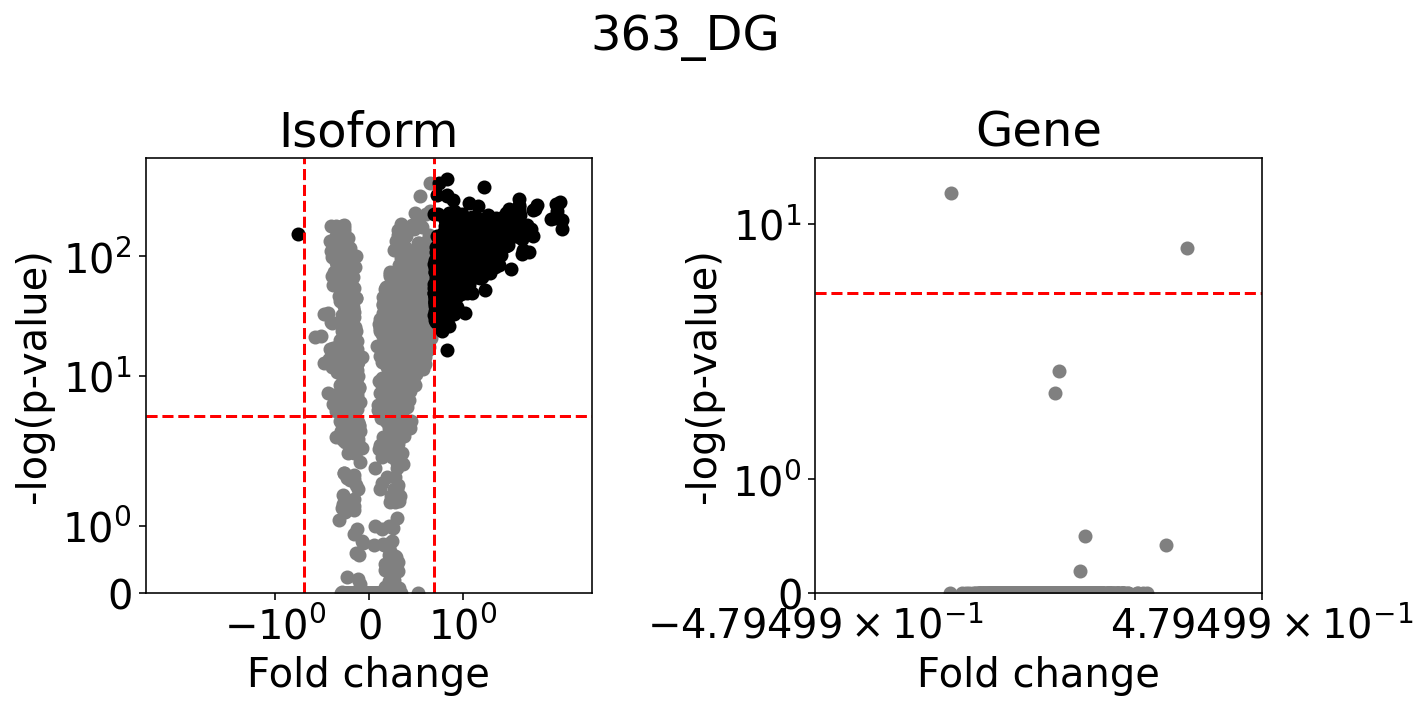

In [32]:
shape = len(specific_clusters)

fig, axs = plt.subplots(figsize=(5*2, 5*shape), ncols=2, nrows=shape)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle(specific_clusters[0])

for blah, (ax, cluster) in enumerate(zip(axs, specific_clusters)):
    idx = np.argwhere(cluster == de_clusters)[0][0]
    data = de_isoforms[idx].query("index == '0'")

    x = data["es"].values.astype(float)
    y = -np.log(data["p_corr"].values.astype(float))

    plot.volcano(x, y, ax[0])
    ax[0].set_title("Isoform")
    ax[1].set_title("Gene")

    data = de_genes[idx].query("index == '0'")
    x = data["es"].values.astype(float)
    y = -np.log(data["p_corr"].values.astype(float))

    plot.volcano(x, y, ax[1])
    
ax[0].remove()
ax[1].remove()

plt.savefig(f"../../figures/split_cluster_volcano_{'-'.join(specific_clusters[0].split(' '))}.png",bbox_inches='tight', dpi=300)

fig.show()

In [33]:
alpha = 0.01

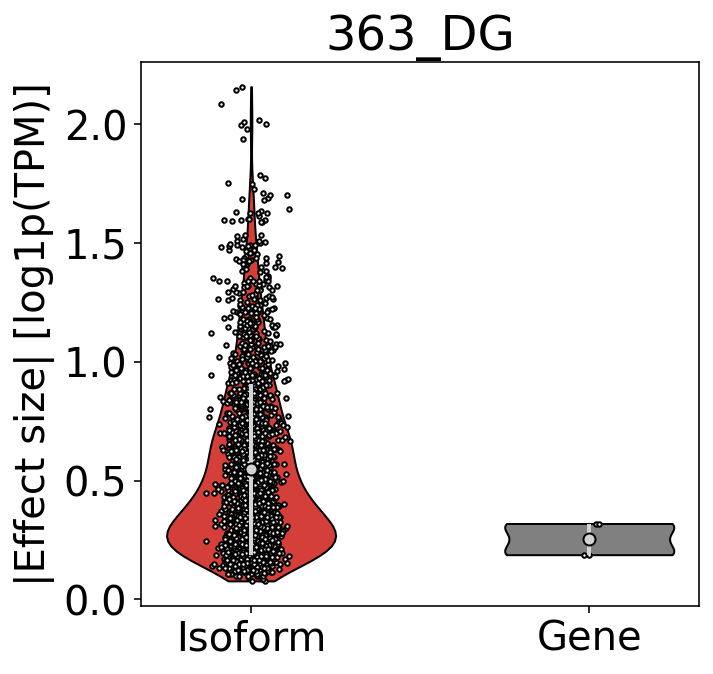

In [34]:
fig, axs = plt.subplots(figsize=(5,5), ncols=1)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

labels = ["Isoform", "Gene"]

ax = axs

cluster = specific_clusters[0]

idx = np.where(cluster == de_clusters)[0][0]

markers_isoform = de_isoforms[idx]
markers_gene = de_genes[idx]

lticks = np.arange(len(labels)) + 1
iso_mask = markers_isoform["p_corr"] < alpha
gen_mask = markers_gene["p_corr"] < alpha

data = [np.abs(markers_isoform["es"].values.astype(float))[iso_mask], np.abs(markers_gene["es"].values.astype(float))[gen_mask]]
plot.violinplot(data,  ax, selected=0)

ax.set(**{
    "xticklabels": labels,
    "xticks": lticks,
    "ylabel": "|Effect size| [log1p(TPM)]",
    "title": f"{cluster}"
 })

plt.savefig(f"../../figures/split_cluster_effect_size_{'-'.join(specific_clusters[0].split(' '))}.png",bbox_inches='tight', dpi=300)


fig.show()

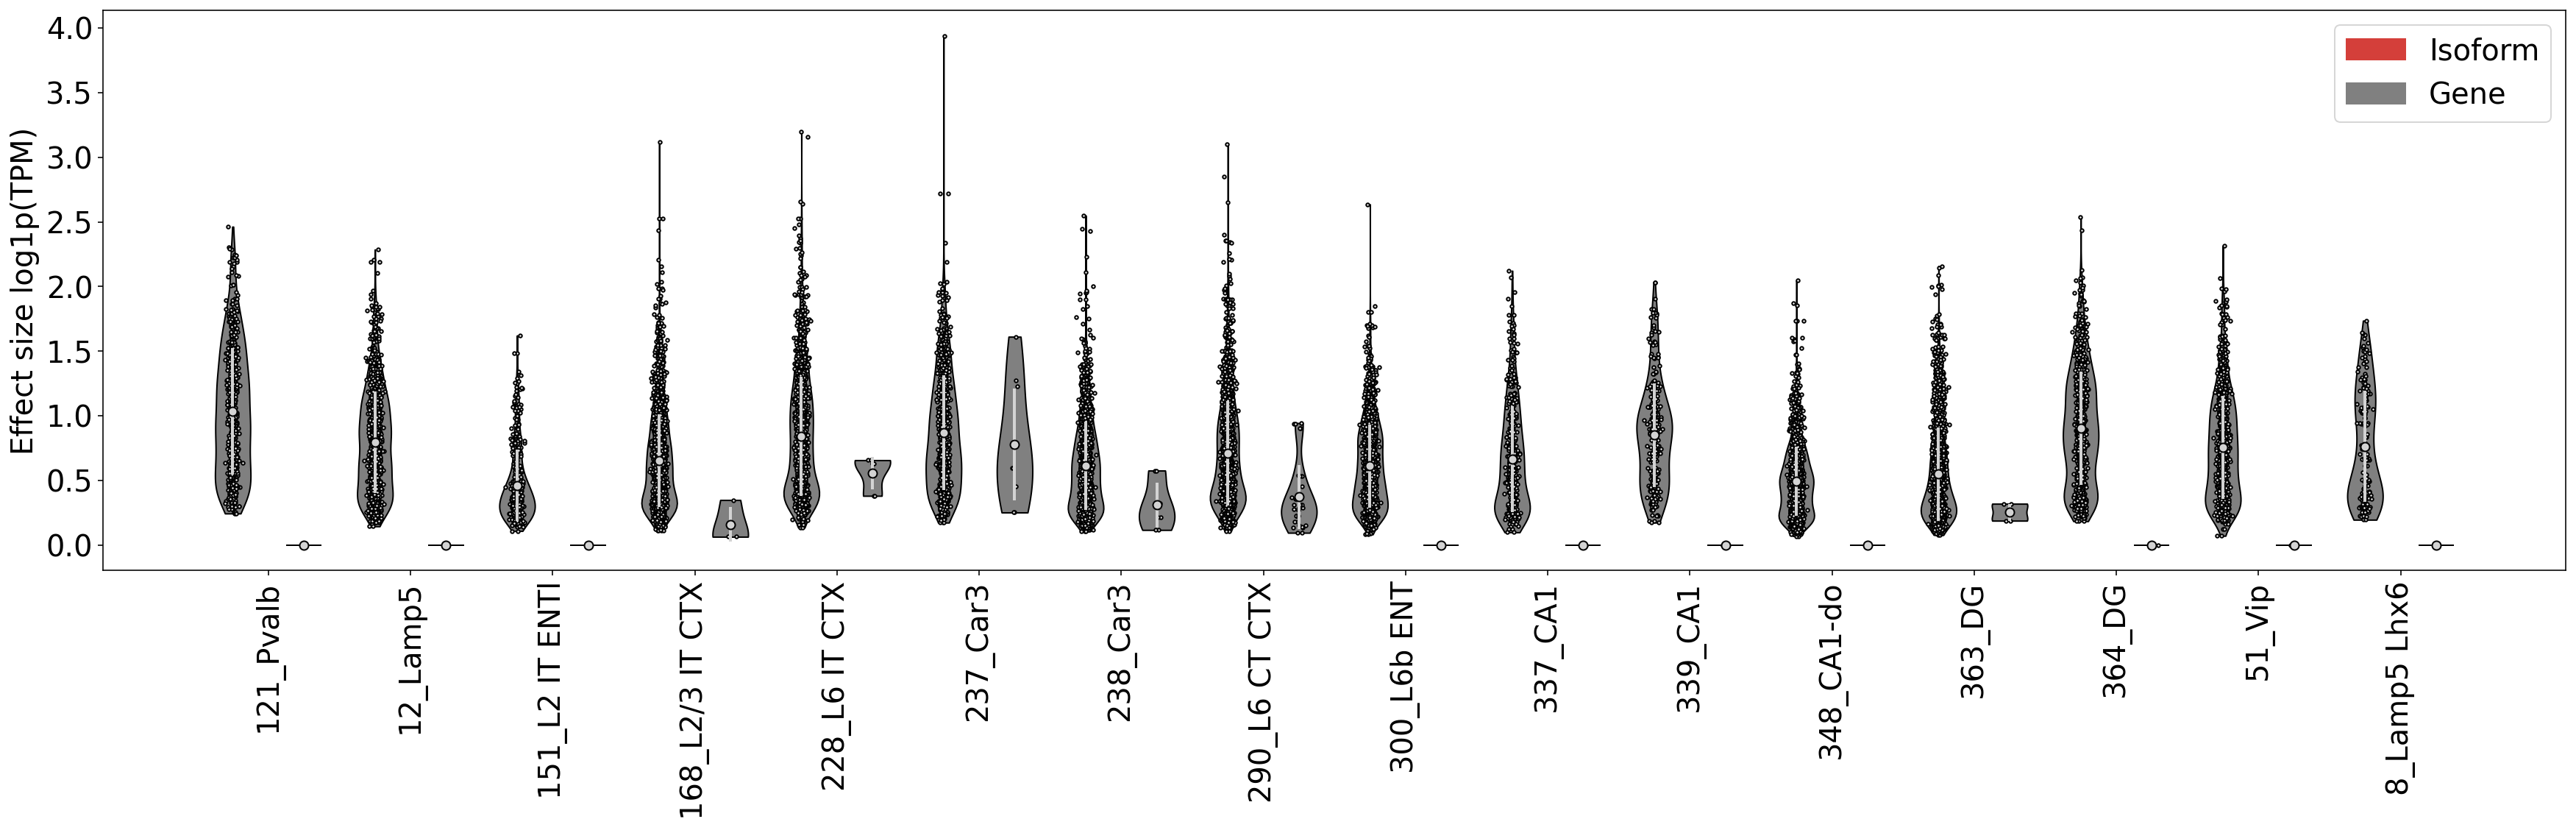

In [35]:
fig, ax = plt.subplots(figsize=(30,7))

labels = ["Isoform", "gene"]
lticks = np.arange(len(labels)) + 1

gees = []
iees = []


for didx, d in enumerate(de_clusters):
    iso_mask = de_isoforms[didx]["p_corr"] < alpha
    gen_mask = de_genes[didx]["p_corr"] < alpha

    i = np.abs(de_isoforms[didx]["es"].values.astype(float))[iso_mask]
    if len(i)==0: i=np.array([0]);
    iees.append(i)
    g = np.abs(de_genes[didx]["es"].values.astype(float))[gen_mask]
    if len(g)==0: g=np.array([0]);
    gees.append(g)


plot.violinplot(gees, ax, **{"xticks": np.arange(1, len(gees)*2, 2) + 1, "color": "grey"})
plot.violinplot(iees, ax, **{"xticks": np.arange(0, len(iees)*2, 2) + 1})

[stats.ttest_ind(i, j) for i, j in zip(iees, gees)]

ax.set(**{
    "xticks": np.arange(0.5, (len(iees))*2, 2)+1,
    "xticklabels": de_clusters,
    "ylabel": "Effect size log1p(TPM)",
})

ax.set_xticklabels(de_clusters, rotation = 90)
red_patch = mpatches.Patch(color="#D43F3A", label='Isoform')
grey_patch = mpatches.Patch(color="grey", label='Gene')
ax.legend(handles=[red_patch, grey_patch])


fig.show()

In [36]:
[stats.ttest_ind(i, j) for i, j in zip(iees, gees)]

[Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=2.384693922741165, pvalue=0.017155861305681076),
 Ttest_indResult(statistic=1.517867307060236, pvalue=0.12921761088538625),
 Ttest_indResult(statistic=0.6265930482615764, pvalue=0.531079633090515),
 Ttest_indResult(statistic=2.5024889938965718, pvalue=0.012407204902423093),
 Ttest_indResult(statistic=5.097052558090342, pvalue=3.716285081330791e-07),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=1.6375660732208699, pvalue=0.10165023823295621),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan)]

# Looking at the specific isoforms

In [37]:
cluster = specific_clusters[0]
idx = np.where(cluster == de_clusters)[0][0]

markers_isoform = de_isoforms[idx]
markers_gene = de_genes[idx]
print(cluster)

363_DG


In [38]:
markers_isoform.sort_values(["es","p_corr"])

,index,name,p_raw,p_corr,es
70493,1,Kifap3-202_ENSMUST00000077642.12,1.3439e-51,1.71079e-48,-1.70367
130630,1,Tmem30a-201_ENSMUST00000034878.12,7.58068e-75,9.6502e-72,-1.62716
69275,1,Actr3-202_ENSMUST00000178474.8,2.35643e-38,2.99974e-35,-1.50909
112892,1,Vcp-201_ENSMUST00000030164.8,3.96392e-101,5.04606e-98,-1.27126
125128,1,Atp1a3-201_ENSMUST00000080882.11,9.14325e-168,1.16394e-164,-1.22453
...,...,...,...,...,...
55923,0,Pak1-201_ENSMUST00000033040.12,2.56922e-108,5.82185e-105,2.01072
18475,0,Sh3bp5-201_ENSMUST00000091903.5,4.80709e-100,1.08929e-96,2.01649
43865,0,Ncdn-203_ENSMUST00000127079.2,1.04243e-128,2.36214e-125,2.085
37067,0,Napb-201_ENSMUST00000028926.13,1.99543e-92,4.52164e-89,2.14398


In [39]:
gene.var[gene.var.gene_name.str.contains("Uba1")]

,transcript_id,gene_id,gene_name,transcript_name,length,txn_list,num_isoforms,gene_counts,dispersion,pass_disp_filter,highly_variable,means,dispersions,dispersions_norm
Uba1_ENSMUSG00000001924.16,ENSMUST00000130694.2,ENSMUSG00000001924.16,Uba1_ENSMUSG00000001924.16,Uba1-203_ENSMUST00000130694.2,575,"['ENSMUST00000130694.2', 'ENSMUST00000089217.1...",6,576.723083,0.018116,True,False,4.327595,3.756033,-0.511787


In [40]:
i = "Uba1-201_ENSMUST00000001989.9"
g = "Uba1_ENSMUSG00000001924.16"

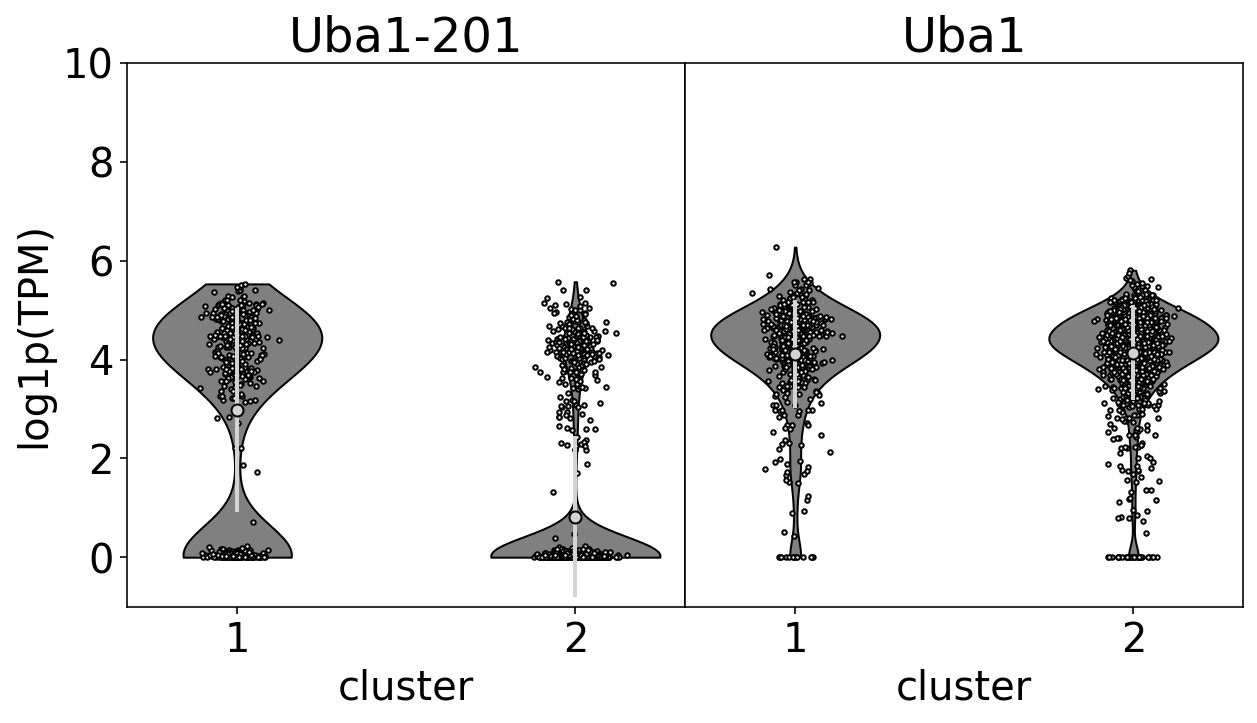

In [41]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

km = np.unique(isoform.obs.km.values)
cluster_mask = isoform.obs.eval(f"cluster_label=='{specific_clusters[0]}'").values.astype(bool)
iso_vector = nd(isoform.layers["log1p"][:, isoform.var.index.values == i].todense())[cluster_mask]
gene_vector = nd(gene.layers["log1p"][:, gene.var.index.values == g].todense())[cluster_mask]

lidx = np.arange(len(km)) + 1
labels = [f"{i}" for i in lidx]
kwd = {
    "xticks" : lidx,
    "xticklabels": labels,
    "xlabel":"cluster",
    "ylim": (-1, 10),
    "ylabel": "log1p(TPM)"
}

ax = axs[0]
mask = isoform.obs[cluster_mask].eval(f"km == '0'")

data = [iso_vector[mask], iso_vector[~mask]]

plot.violinplot(data, ax)

ax.set_title(f"{i.split('_')[0]}")
ax.set(**kwd)



ax = axs[1]
mask = gene.obs[cluster_mask].eval(f"km == '0'")
data = [gene_vector[mask], gene_vector[~mask]]

plot.violinplot(data,ax)

ax.set_title(f"{g.split('_')[0]}")
kwd["yticks"] = []
kwd["yticklabels"] = []
kwd["ylabel"] = ""
ax.set(**kwd)

plt.savefig(f"../../figures/split_cluster_{i.split('_')[0]}.png",bbox_inches='tight', dpi=300)


fig.show()

In [42]:
i.split('_')[0]

'Uba1-201'

In [43]:
stats.ttest_ind(*data)

Ttest_indResult(statistic=-0.5052224210720189, pvalue=0.6134631979117748)

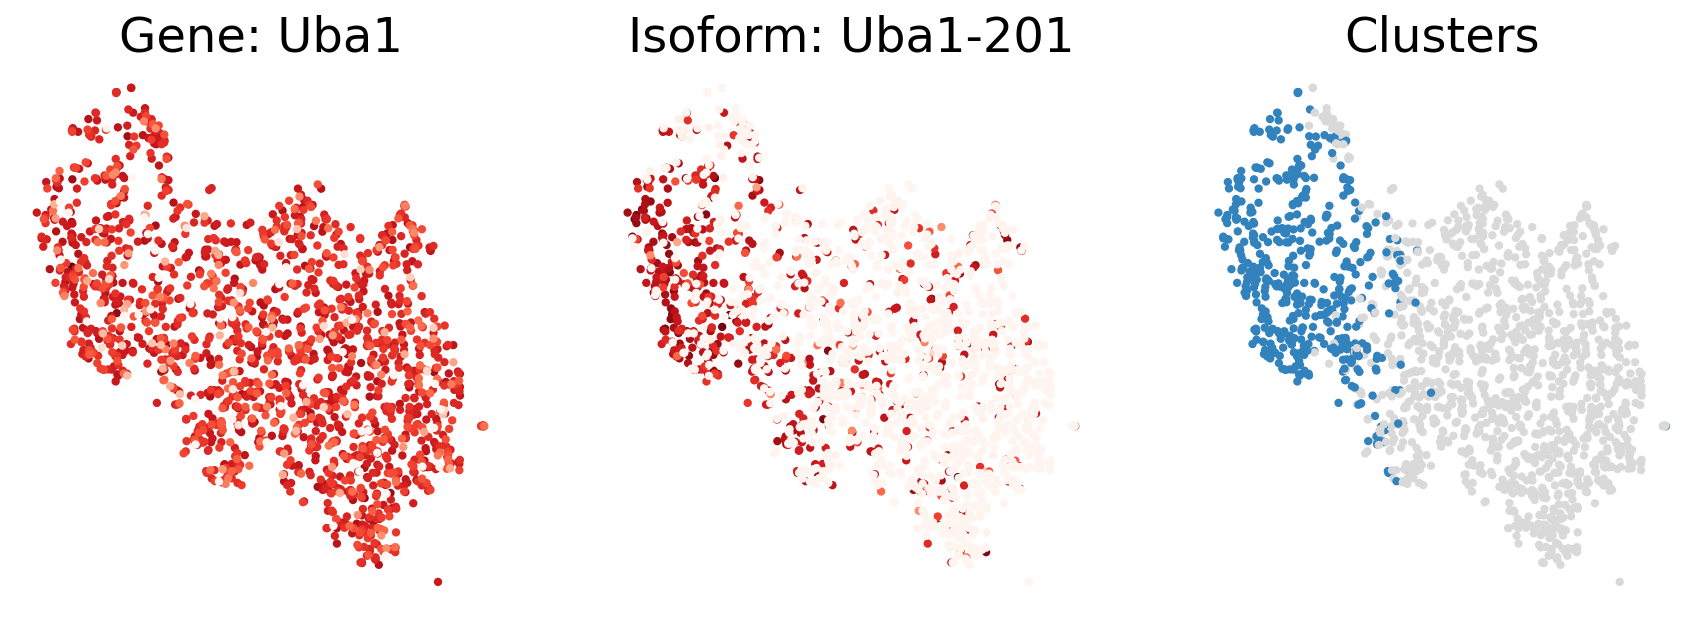

In [44]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

X = isoform.obsm["X_nca_tsne"][cluster_mask]

Yi = isoform.layers["log1p"][:, isoform.var.index.values == i][cluster_mask]
Yg = gene.layers["log1p"][:, gene.var.index.values == g][cluster_mask]

ax = axs[0] # gene

x = X[:,0]
y = X[:,1]
c = nd(Yg.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=10)
ax.set_axis_off()
ax.set_title(f"Gene: {g.split('_')[0]}")


ax = axs[1] # isoform

x = X[:,0]
y = X[:,1]
c = nd(Yi.todense())
argsort = np.argsort(c)[::-1]
x = x[argsort]
y = y[argsort]
c = c[argsort]

ax.scatter(x,y, c=c, cmap="Reds", s=10)
ax.set_axis_off()
ax.set_title(f"Isoform: {i.split('_')[0]}")

ax = axs[2] # clusters

x = X[:,0]
y = X[:,1]
c = isoform.obs[cluster_mask].km.values

ax.scatter(x,y, c=c, cmap="tab20c", s=10)
ax.set_axis_off()
ax.set_title("Clusters")

plt.savefig(f"../../figures/split_cluster_tsne_nca_{i.split('_')[0]}.png",bbox_inches='tight', dpi=300)

fig.show()

In [45]:
markers_isoform[markers_isoform.name.str.contains("Uba1").values]

,index,name,p_raw,p_corr,es
68006,0,Uba1-201_ENSMUST00000001989.9,4.81763e-78,1.09168e-74,2.15768


In [46]:
idx = np.where(cluster == de_clusters)[0][0]

In [47]:
idx

12

In [48]:
cluster

'363_DG'

In [49]:
de_isoforms[idx][de_isoforms[idx].name.str.contains("Uba1").values]

,index,name,p_raw,p_corr,es
68006,0,Uba1-201_ENSMUST00000001989.9,4.81763e-78,1.09168e-74,2.15768


In [50]:
de_isoforms[idx][de_isoforms[idx].name.str.contains("Pink").values]

,index,name,p_raw,p_corr,es
43273,0,Pink1-201_ENSMUST00000030536.13,1.53047e-66,3.46804e-63,1.43678


In [51]:
np.sum([de_isoforms[i].query(f"p_corr < {alpha}").shape[0]>0 for i in range(len(de_isoforms))])

16